### Przygotowanie danych

In [76]:
# pip install requirements.txt

In [77]:
import pandas as pd #tabele
import numpy as np #np. wektory, listy
import matplotlib.pyplot as plt #wykresy
import seaborn as sns #wykresy korelacji
from scipy import stats #kruskal-wallis, mann-whitney
from sklearn.impute import KNNImputer
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
#from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
import missingno as msno
from sktime.transformations.series.impute import Imputer
import warnings

In [78]:
df0 = pd.read_excel("..\\gasometry_data\\dane_surowe_gaz.xlsx", sheet_name="Arkusz1")

In [79]:
df0=df0.pivot_table(index=("PACJENT_NR", "BADANIE_NR", "ZGON"), columns=["KOD_BADANIA"], values=["WYNIK"]) #ustawienie wyników w kolumnach
df0.reset_index(inplace=True) #rozpakowanie indeksów
df0.columns.name="Lp"
df0.columns=['PACJENT_NR','BADANIE_NR', 'ZGON', 'BETET', 'CO2TET', 'HCO3ACTE', 'HCO3STTE', 'O2SATTET', 'O2TET', 'PHTET']
#zamiana PH na liczbę jonów wodoru, min:35 , max: 45 (im więcej, tym niższe PH)
df0["IONH"]=10**(9-df0["PHTET"])

In [80]:
df0.head()

,PACJENT_NR,BADANIE_NR,ZGON,BETET,CO2TET,HCO3ACTE,HCO3STTE,O2SATTET,O2TET,PHTET,IONH
0,1,1,NIE,-0.8,57.1,26.1,21.9,82.6,57.0,7.269,53.826978
1,1,2,NIE,-1.9,87.2,26.2,21.8,99.3,197.0,NaN,NaN
2,1,3,NIE,1.2,66.0,28.5,24.2,99.6,225.0,7.244,57.016427
3,1,4,NIE,1.7,62.5,28.6,23.7,98.1,111.0,7.269,53.826978
4,1,5,NIE,0.5,61.1,27.5,23.9,99.1,145.0,7.262,54.701596


### Filtrowanie pacjentów >6 pomiarów

In [81]:
id_df=df0[["PACJENT_NR","BADANIE_NR"]].groupby('PACJENT_NR').max().add_suffix('_liczba')>6
id6=id_df.index[id_df["BADANIE_NR_liczba"]]
df_filtr=df0[df0['PACJENT_NR'].isin(id6)]
df_filtr

,PACJENT_NR,BADANIE_NR,ZGON,BETET,CO2TET,HCO3ACTE,HCO3STTE,O2SATTET,O2TET,PHTET,IONH
0,1,1,NIE,-0.8,57.1,26.1,21.9,82.6,57.0,7.269,53.826978
1,1,2,NIE,-1.9,87.2,26.2,21.8,99.3,197.0,NaN,NaN
2,1,3,NIE,1.2,66.0,28.5,24.2,99.6,225.0,7.244,57.016427
3,1,4,NIE,1.7,62.5,28.6,23.7,98.1,111.0,7.269,53.826978
4,1,5,NIE,0.5,61.1,27.5,23.9,99.1,145.0,7.262,54.701596
...,...,...,...,...,...,...,...,...,...,...,...
3040,145,5,TAK,-5.6,51.3,21.8,19.6,95.9,85.5,7.237,57.942870
3041,145,6,TAK,-6.4,48.9,20.9,19.2,98.8,116.0,7.240,57.543994
3042,145,7,TAK,-7.2,52.1,20.7,18.4,94.7,82.9,7.207,62.086903
3043,145,8,TAK,-5.5,46.5,21.4,19.9,98.1,115.0,7.271,53.579666


### Poszukiwanie najlepszej metody uzupełniania braków danych

In [82]:
df_na=df_filtr.copy()
cols=["BETET",	"CO2TET",	"HCO3ACTE",	"HCO3STTE",	"O2SATTET",	"O2TET", "IONH"]
df_na["czy_na"]=df_na[cols].apply(lambda row: any(row.isna()), axis=1)
id=df_na[df_na["czy_na"]==True]["PACJENT_NR"]
df_bezna = df_na[~df_na['PACJENT_NR'].isin(id)]
df_bezna = df_bezna[["PACJENT_NR", *cols]]
df_bezna

,PACJENT_NR,BETET,CO2TET,HCO3ACTE,HCO3STTE,O2SATTET,O2TET,IONH
50,2,-2.5,67.2,26.9,21.7,87.4,65.7,60.255959
51,2,1.1,64.0,28.1,23.7,95.8,96.7,54.827696
52,2,2.7,72.3,30.1,24.6,96.9,109.1,57.942870
53,2,1.1,69.7,30.4,24.5,95.1,89.3,55.335011
54,2,2.8,57.3,30.1,26.2,97.3,100.8,45.814189
...,...,...,...,...,...,...,...,...
3040,145,-5.6,51.3,21.8,19.6,95.9,85.5,57.942870
3041,145,-6.4,48.9,20.9,19.2,98.8,116.0,57.543994
3042,145,-7.2,52.1,20.7,18.4,94.7,82.9,62.086903
3043,145,-5.5,46.5,21.4,19.9,98.1,115.0,53.579666


In [83]:
np.random.seed(13)
num_values_to_remove =int(0.2*len(df_bezna))
rows_to_remove = np.random.choice(df_bezna.index, size=num_values_to_remove, replace=True)
cols_to_remove = np.random.choice(df_bezna.columns[3:11], size=num_values_to_remove, replace=True)
id=zip(rows_to_remove, cols_to_remove)
df_nowe=df_bezna.copy()

for row, col in id:
  df_nowe.loc[row, col] = np.nan

4

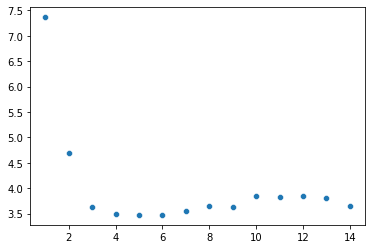

In [92]:
a=list()
for i in range(1,15):
  kmni_imputer = KNNImputer(n_neighbors=i)
  kmni=kmni_imputer.fit_transform(df_nowe[cols])
  a.append(mean_squared_error(df_bezna[cols], kmni))
sns.scatterplot(x=list(range(1,15)), y=a)
min(range(len(a)),key=lambda i: a[i])

In [95]:
a[4]

3.4737478902562695

In [97]:

imputers = {
    "mean": Imputer(method="mean"),
    "median": Imputer(method="median"),
    "drift": Imputer(method="drift"),
    "backfill": Imputer(method="backfill"),
    "knn_p": KNNImputer(n_neighbors=5)
}

pacjenci_df = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for imp_name, imp in imputers.items():
        pacjenci_df[imp_name] = np.concatenate(
            [imp.fit_transform(pacjent_df[cols]) for _, pacjent_df in df_nowe.groupby(by='PACJENT_NR')],
            axis=0
        )
        pacjenci_df[imp_name] = pd.DataFrame(pacjenci_df[imp_name], columns=cols)

kmni_imputer = KNNImputer(n_neighbors=5)
pacjenci_df["knn_all"]=kmni_imputer.fit_transform(df_nowe[cols])


In [98]:
print("Podstawienie średniego wyniku pacjenta: ", str(np.round(mean_squared_error(df_bezna[cols], pacjenci_df['mean']), 4)))
print("Podstawienie mediany wyników pacjenta: ", str(np.round(mean_squared_error(df_bezna[cols], pacjenci_df['median']), 4)))
print("drift ", str(np.round(mean_squared_error(df_bezna[cols], pacjenci_df['drift']), 4)))
print("backfill ", str(np.round(mean_squared_error(df_bezna[cols], pacjenci_df['backfill']), 4)))
print("Metoda najbliższych sąsiadów k=1 na pacjentach: ", str(np.round(mean_squared_error(df_bezna[cols], pacjenci_df['knn_p']),4)))
print("Metoda najbliższych sąsiadów k=1 na wszystkich: ", str(np.round(mean_squared_error(df_bezna[cols], pacjenci_df['knn_all']),4)))

Podstawienie średniego wyniku pacjenta:  8.4726
Podstawienie mediany wyników pacjenta:  9.135
drift  7.0611
backfill  10.2497
Metoda najbliższych sąsiadów k=1 na pacjentach:  6.0237
Metoda najbliższych sąsiadów k=1 na wszystkich:  3.4737


### Uzupełnienie danych najlepszą metoda

In [5]:
#wypełnianie braków metodą K najbliższych sąsiadów
imputer = KNNImputer(n_neighbors=3)
df=df0.copy()
numeric_cols = df.columns[~df.columns.isin(["ZGON"])]
transforms=imputer.fit_transform(df.loc[:, numeric_cols])
df.loc[:, numeric_cols] = transforms
df.head()


<ipython-input-5-b52bdcbb5c99>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, numeric_cols] = transforms


,PACJENT_NR,BADANIE_NR,ZGON,BETET,CO2TET,HCO3ACTE,HCO3STTE,O2SATTET,O2TET,PHTET,IONH
0,1.0,1.0,NIE,-0.8,57.1,26.1,21.9,82.6,57.0,7.269000,53.826978
1,1.0,2.0,NIE,-1.9,87.2,26.2,21.8,99.3,197.0,7.090333,82.076160
2,1.0,3.0,NIE,1.2,66.0,28.5,24.2,99.6,225.0,7.244000,57.016427
3,1.0,4.0,NIE,1.7,62.5,28.6,23.7,98.1,111.0,7.269000,53.826978
4,1.0,5.0,NIE,0.5,61.1,27.5,23.9,99.1,145.0,7.262000,54.701596


In [6]:
id_df=df[["PACJENT_NR","BADANIE_NR"]].groupby('PACJENT_NR').max().add_suffix('_liczba')>6
id6=id_df.index[id_df["BADANIE_NR_liczba"]]
id6

Float64Index([  1.0,   2.0,   3.0,   4.0,   6.0,   7.0,   8.0,  10.0,  11.0,
               12.0,
              ...
              129.0, 131.0, 132.0, 133.0, 134.0, 139.0, 140.0, 142.0, 144.0,
              145.0],
             dtype='float64', name='PACJENT_NR', length=107)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'BE'),
  Text(1.5, 0, 'pCO$_2$'),
  Text(2.5, 0, 'act. \n HCO$_3$ '),
  Text(3.5, 0, 'std. \n  HCO$_3$'),
  Text(4.5, 0, 'O$_2$ sat.'),
  Text(5.5, 0, 'pO$_2$'),
  Text(6.5, 0, 'pH'),
  Text(7.5, 0, '[H$^\\plus$]')])

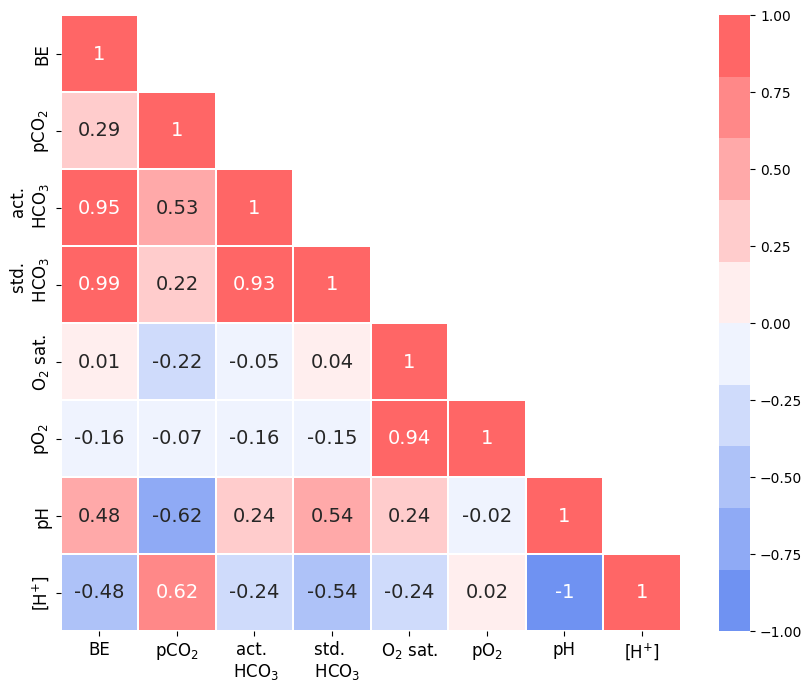

In [8]:
cmap= sns.blend_palette(["#6F92F2","white", "#FF6666"], n_colors=10)
df_corr=df6[[
 'BETET',
 'CO2TET',
 'HCO3ACTE',
 'HCO3STTE',
 'O2SATTET',
 'O2TET','PHTET',
 'IONH']].corr(method='spearman')

df_corr_rounded = df_corr.round(2)
mask = ~np.tril(np.ones(df_corr.shape[1])).astype(bool)

fig, ax = plt.subplots(figsize=(10,8))
fig=sns.heatmap(df_corr_rounded, cmap=cmap, annot=True, mask=mask, linewidths=0.1, annot_kws=dict(size=14))
ax.set_xticklabels(["BE","pCO$_2$", "act. \n HCO$_3$ ", "std. \n  HCO$_3$", "O$_2$ sat." ,"pO$_2$", "pH","[H$^\plus$]" ])
ax.set_yticklabels(["BE","pCO$_2$", "act. \n HCO$_3$ ", "std. \n  HCO$_3$", "O$_2$ sat." ,"pO$_2$", "pH","[H$^\plus$]" ])
sns.set()
plt.xticks(size=12)
plt.yticks(size=12)
plt.xticks(rotation=0)


In [9]:
df.to_csv("dane_uzupelnione_knn_gazometria.csv")


In [10]:
#normalizacja: 0-min, 1-max
df1=df6.copy()
df1["BETET"] = (df1["BETET"] - (-2.3))/(2.3 - -(2.3))
df1["IONH"] = (df1["IONH"] - 35)/(45 - 35)
df1["O2SATTET"] = (df1["O2SATTET"] - 95)/(100 - 95)
df1["CO2TET"] = (df1["CO2TET"] - 35)/(45 - 35)
df1["O2TET"] = (df1["O2TET"] - 75)/(100 - 75)
df1["HCO3STTE"] = (df1["HCO3STTE"] - 22)/(28 - 22)
df1["HCO3ACTE"] = (df1["HCO3ACTE"] - 22)/(28 - 22)
df1["ZGON"] = np.where(df1["ZGON"] == "NIE", 0, 1)
df1["PHTET"] = (df1["PHTET"] - 7.35)/(7.45 - 7.35)
yeslist = ["PACJENT_NR","BETET", "IONH", "O2SATTET",  "CO2TET"] #"HCO3STTE", "HCO3ACTE", "O2TET"

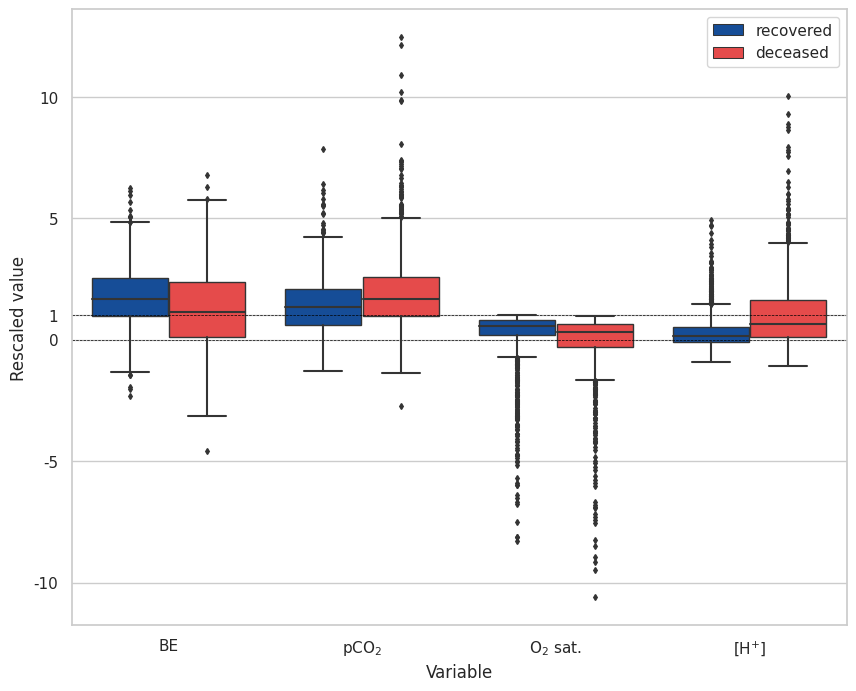

In [14]:
df_catplot=df1[[ "BETET", "CO2TET", "O2SATTET", "IONH","ZGON"]].copy()
df_catplot["ZGON"].replace({0: "recovered", 1: "deceased"}, inplace=True)
df_transformed = pd.melt(df_catplot, id_vars=['ZGON'], var_name='variable', value_name='value')

plt.figure(figsize=(10, 8))
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=1, color='black', linestyle='--', linewidth=0.5)
sns.boxplot(data=df_transformed, x='variable', y='value', hue="ZGON", palette={'recovered': "#004AAD", 'deceased': "#FF3131"},
            fliersize=3, boxprops=dict(linewidth=1), meanprops=dict(linewidth=0.1))
sns.set(style="whitegrid")

plt.xlabel('Variable')
plt.ylabel('Rescaled value')
plt.yticks(ticks=[-10, -5, 0,  1, 5, 10], labels=[-10, -5, 0,  1, 5, 10])
plt.xticks(ticks=[0,1,2,3,], labels=["BE","pCO$_2$", "O$_2$ sat.", "[H$^\plus$]"])
plt.legend(title="")

In [15]:
from scipy.stats import ttest_ind
df6[df6["BADANIE_NR"]==1].groupby("ZGON").mean()
df6[df6["BADANIE_NR"]==1].groupby("ZGON").std()

group1 = df6[((df6["BADANIE_NR"]==1) & (df6["ZGON"]=="TAK"))]
group2 = df6[((df6["BADANIE_NR"]==1) & (df6["ZGON"]=="NIE"))]

#perform Welch's t-test
print(ttest_ind(group1['BETET'], group2['BETET']))
print(ttest_ind(group1['IONH'], group2['IONH']))
print(ttest_ind(group1['CO2TET'], group2['CO2TET']))
print(ttest_ind(group1['O2SATTET'], group2['O2SATTET']))

TtestResult(statistic=-3.4583260553747928, pvalue=0.0007863330735616054, df=105.0)
TtestResult(statistic=2.259007503805185, pvalue=0.025949126974587185, df=105.0)
TtestResult(statistic=0.05707033264441401, pvalue=0.9545976319948715, df=105.0)
TtestResult(statistic=-0.09856167387608457, pvalue=0.9216742164559095, df=105.0)


<ipython-input-16-890d52665c60>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  fig1=sns.lineplot(data=df_line, x="BADANIE_NR", y='IONH', hue="ZGON", ci='sd', palette={'recovered': "#6F92F2", 'deceased': "#FF6666"}),


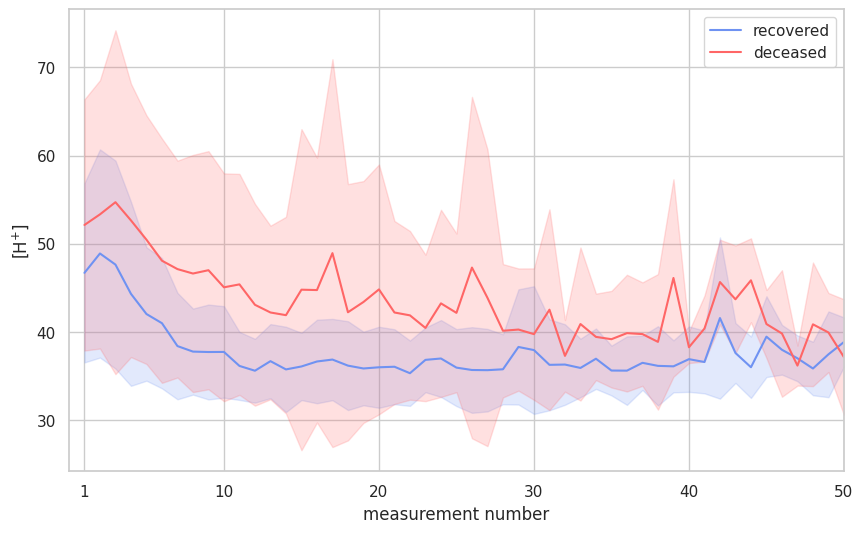

In [16]:
df_line=df6[[ "BADANIE_NR", "IONH","ZGON"]].copy()
df_line["ZGON"].replace({"NIE": "recovered", "TAK": "deceased"}, inplace=True)
# sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
fig1=sns.lineplot(data=df_line, x="BADANIE_NR", y='IONH', hue="ZGON", ci='sd', palette={'recovered': "#6F92F2", 'deceased': "#FF6666"}),

plt.xlabel('measurement number')
plt.ylabel('[H$^{\plus}$]')
plt.xlim(0,50)
plt.xticks(ticks=[1,10,20,30,40,50])
plt.legend(title="")


<ipython-input-17-8879c9351fc1>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  fig2=sns.lineplot(data=df_line, x="BADANIE_NR", y='CO2TET', hue="ZGON", ci='sd', palette={'recovered': "#6F92F2", 'deceased': "#FF6666"})


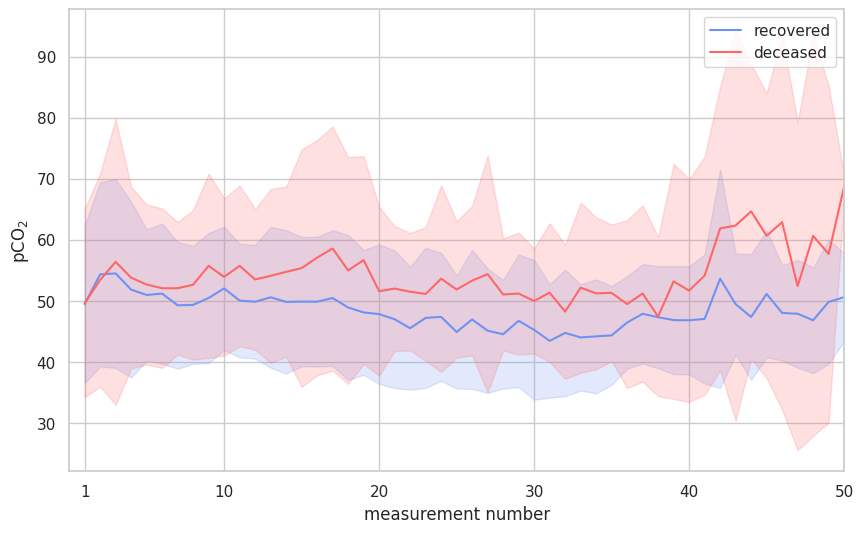

In [17]:
df_line=df6[[ "BADANIE_NR", "CO2TET","ZGON"]].copy()
df_line["ZGON"].replace({"NIE": "recovered", "TAK": "deceased"}, inplace=True)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
fig2=sns.lineplot(data=df_line, x="BADANIE_NR", y='CO2TET', hue="ZGON", ci='sd', palette={'recovered': "#6F92F2", 'deceased': "#FF6666"})

plt.xlabel('measurement number')
plt.ylabel('pCO$_2$')
plt.xlim(0,50)
plt.xticks(ticks=[1,10,20,30,40,50])
plt.legend(title="")

In [43]:
df_line=df6[[ "BADANIE_NR", "O2SATTET","ZGON"]].copy()
df_line["ZGON"].replace({"NIE": "recovered", "TAK": "deceased"}, inplace=True)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
fig3=sns.lineplot(data=df_line, x="BADANIE_NR", y='O2SATTET', hue="ZGON", ci='sd', palette={'recovered': "#6F92F2", 'deceased': "#FF6666"})

plt.xlabel('measurement number')
plt.ylabel('O$_2$ saturation')
plt.xlim(0,50)
plt.xticks(ticks=[1,10,20,30,40,50])
plt.legend(title="")

SyntaxError: ignored

<ipython-input-19-4531ae8b0698>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  fig4=sns.lineplot(data=df_line, x="BADANIE_NR", y='BETET', hue="ZGON", ci='sd', palette={'recovered': "#6F92F2", 'deceased': "#FF6666"})


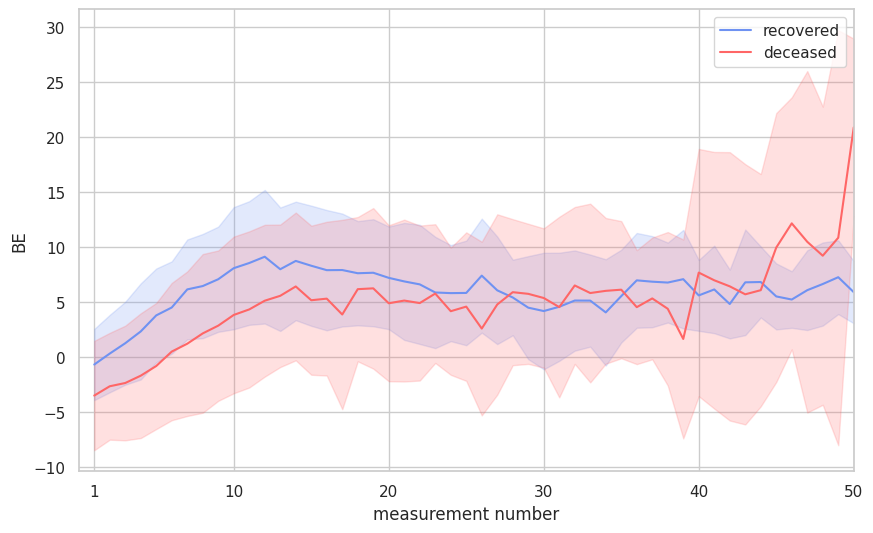

In [19]:
df_line=df6[[ "BADANIE_NR", "BETET","ZGON"]].copy()
df_line["ZGON"].replace({"NIE": "recovered", "TAK": "deceased"}, inplace=True)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
fig4=sns.lineplot(data=df_line, x="BADANIE_NR", y='BETET', hue="ZGON", ci='sd', palette={'recovered': "#6F92F2", 'deceased': "#FF6666"})

plt.xlabel('measurement number')
plt.ylabel('BE')
plt.xlim(0,50)
plt.xticks(ticks=[1,10,20,30,40,50])
plt.legend(title="")

In [20]:
import plotly.express as px
px.scatter(df6, x="IONH", y="PHTET", width=600)



In [21]:
from itertools import groupby
def rle(data):
  x = [len(list(y)) for x, y in groupby(data) if x==True]
  if x==[]:
    return 0
  return max(x)

In [22]:
#Obliczenie różnic
dfr=df.copy()
nr_pacjenta=dfr["PACJENT_NR"]
dfr2=dfr[yeslist].groupby('PACJENT_NR').diff()
dfr3=pd.concat([nr_pacjenta, dfr2], axis=1)
dfr_mdiff=dfr3.groupby('PACJENT_NR').mean().add_suffix('_mdiff')
#dfr_mdiff


In [23]:
df_mean = df[yeslist].groupby('PACJENT_NR').mean().add_suffix('_mean')
df_min = df[yeslist].groupby('PACJENT_NR').min().add_suffix('min')
df_max = df[yeslist].groupby('PACJENT_NR').max().add_suffix('max')
df_med = df[yeslist].groupby('PACJENT_NR').median().add_suffix('median')
df_size = df[['PACJENT_NR', 'BADANIE_NR']].groupby('PACJENT_NR').count().add_suffix('_size')
df_std = df[yeslist].groupby('PACJENT_NR').std().add_suffix('_std')
df_sum = df[yeslist].groupby('PACJENT_NR').sum().add_suffix('_sum')

df_rzad_pom_ups=pd.concat([df1["PACJENT_NR"],df1[["BETET", "IONH", "O2SATTET", "CO2TET"]]>1], axis=1) #"O2TET", "HCO3STTE", "HCO3ACTE"
df_rzad_ups=df_rzad_pom_ups.groupby("PACJENT_NR").agg(rle).add_suffix('_rzad_ups')

df_rzad_pom_downs=pd.concat([df1["PACJENT_NR"],df1[["BETET", "IONH", "O2SATTET", "CO2TET"]]<0], axis=1) #"O2TET", "HCO3STTE", "HCO3ACTE"
df_rzad_downs=df_rzad_pom_downs.groupby("PACJENT_NR").agg(rle).add_suffix('_rzad_downs')

df_zgon = df1[['PACJENT_NR', 'ZGON']].groupby('PACJENT_NR').first()


#Zliczanie wyników za niskich
df_no_drops = df1.copy()
for col in yeslist:
    if col != "PACJENT_NR":
        df_no_drops[col] = np.where(df1[col] < 0, 1, 0) #1-za niski, 0-nie za niski

#Zliczanie wyników za wysokich
df_no_ups = df1.copy()
for col in yeslist:
    if col != "PACJENT_NR":
        df_no_ups[col] = np.where(df1[col] > 1, 1, 0) #1-za wysoki, 0-nie za wysoki

#Zliczanie wyników poza normą drop-poniżej up-powyżej
df_no_dropup = df1.copy()
for col in yeslist:
    if col != "PACJENT_NR": #dla innych kolumn niż numer pacjenta
        df_no_dropup[col] = df_no_ups[col] + df_no_drops[col]

#Dodanie kolumny nOK zliczającej, ile wyników pacjent miał ok
df_no_dropup["nOK"] = 0
for col in yeslist:
    if col != "PACJENT_NR":
        df_no_dropup["nOK"] += df_no_dropup[col]

#Dodanie kolumny sOK, która przyjmuje wartość 1, gdy wszystkie wyniki były ok
df_no_dropup["sOK"] = np.where(df_no_dropup["nOK"] == 0, 1, 0)

#wypisz tablicę wszystkich wyników
#print(df_no_dropup)

#agregacja
df_no_drops = df_no_drops[yeslist].groupby('PACJENT_NR').sum().add_suffix('_no_drops')
df_no_ups = df_no_ups[yeslist].groupby('PACJENT_NR').sum().add_suffix('_no_up')
df_no_dropup = df_no_dropup[["PACJENT_NR","BETET", "IONH", "O2SATTET", "CO2TET", "nOK", "sOK"]].groupby('PACJENT_NR').sum().add_suffix('_no_dropup')

#"O2TET", "HCO3STTE", "HCO3ACTE"

#łącznie
df_list = [df_size,df_zgon, df_min, df_max, df_no_drops, df_no_ups, df_no_dropup, dfr_mdiff, df_rzad_ups, df_rzad_downs]
#'df_mean, df_med, df_std, df_sum'
df_all = pd.concat(df_list, axis=1)


#usuwanie kolumn
df_all.drop(columns=["O2SATTET_no_up", "O2SATTET_no_dropup", "O2SATTET_rzad_ups" ,  "O2SATTETmax"], inplace=True) #"O2TETmax" ,  "O2SATTETmax"


In [24]:
# df_all.to_csv("pacjenci_statystyki_gazometria.csv")
df_all.columns

Index(['BADANIE_NR_size', 'ZGON', 'BETETmin', 'IONHmin', 'O2SATTETmin',
       'CO2TETmin', 'BETETmax', 'IONHmax', 'CO2TETmax', 'BETET_no_drops',
       'IONH_no_drops', 'O2SATTET_no_drops', 'CO2TET_no_drops', 'BETET_no_up',
       'IONH_no_up', 'CO2TET_no_up', 'BETET_no_dropup', 'IONH_no_dropup',
       'CO2TET_no_dropup', 'nOK_no_dropup', 'sOK_no_dropup', 'BETET_mdiff',
       'IONH_mdiff', 'O2SATTET_mdiff', 'CO2TET_mdiff', 'BETET_rzad_ups',
       'IONH_rzad_ups', 'CO2TET_rzad_ups', 'BETET_rzad_downs',
       'IONH_rzad_downs', 'O2SATTET_rzad_downs', 'CO2TET_rzad_downs'],
      dtype='object')

In [25]:
df_all = df_all[df_all["BADANIE_NR_size"] > 6]
df_all["ZGON"].replace({0: "recovered", 1: "deceased"}, inplace=True)
df2_dead = df_all[df_all["ZGON"]=="deceased"].copy()
df2_life = df_all[df_all["ZGON"]=="recovered"].copy()

df2_dead.drop(columns=["ZGON"], inplace=True)
df2_life.drop(columns=["ZGON"], inplace=True)
df2_dead.columns

Index(['BADANIE_NR_size', 'BETETmin', 'IONHmin', 'O2SATTETmin', 'CO2TETmin',
       'BETETmax', 'IONHmax', 'CO2TETmax', 'BETET_no_drops', 'IONH_no_drops',
       'O2SATTET_no_drops', 'CO2TET_no_drops', 'BETET_no_up', 'IONH_no_up',
       'CO2TET_no_up', 'BETET_no_dropup', 'IONH_no_dropup', 'CO2TET_no_dropup',
       'nOK_no_dropup', 'sOK_no_dropup', 'BETET_mdiff', 'IONH_mdiff',
       'O2SATTET_mdiff', 'CO2TET_mdiff', 'BETET_rzad_ups', 'IONH_rzad_ups',
       'CO2TET_rzad_ups', 'BETET_rzad_downs', 'IONH_rzad_downs',
       'O2SATTET_rzad_downs', 'CO2TET_rzad_downs'],
      dtype='object')

In [26]:
# plt.figure(figsize=(10,5))

# fig = sns.barplot(y=df2_dead["BADANIE_NR_size"], x=df2_dead.index, color="red",
#                    label='deceased')


In [27]:
#metoda Manna-Whitneya
tabela_MN=pd.DataFrame(columns=("nazwa", "statystyka", "p-wartosc"))
for column in df2_dead.columns:
    kw = stats.mannwhitneyu(df2_dead[column], df2_life[column])
    new_row = {"nazwa": column, "statystyka": kw[0], "p-wartosc": kw[1]}
    tabela_MN = pd.concat([tabela_MN, pd.DataFrame([new_row])], ignore_index=True)
nazwy_sign=tabela_MN[tabela_MN["p-wartosc"]<0.05].nazwa

In [28]:
tabela_MN.to_csv("tabela_MN.csv")

In [29]:
len(nazwy_sign)

18

In [30]:
#korelacje zmiennych znaczących
# zmienne_sign=df_all[nazwy_sign]
# cmap = sns.diverging_palette(240, 10, as_cmap=True)
# zmienne_sign_corr=zmienne_sign.corr()
# sns.heatmap(zmienne_sign.corr(), cmap=cmap)

In [31]:
# tab_corr=zmienne_sign_corr.unstack().to_frame().reset_index()
# tab_corr.columns=["Zmienna 1", "Zmienna 2", "Wartość"]
# tab_corr.to_csv("lista_korelacji.csv")
# zmienne_sign_corr.to_csv("tabela_korelcji.csv")
# zmienne_sign_corr

In [32]:
# #drzewo decyzyjne bez kroswalidacji
# X=df_all[nazwy_sign]
# y=df_all["ZGON"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
# model = tree.DecisionTreeClassifier(random_state=5, max_depth=3)
# model = model.fit(X_train, y_train)
# y_pred=model.predict(X_test)
# acc=accuracy_score(y_test, y_pred)
# print("Dokładność drzewa: ", acc)
# #confusion = confusion_matrix(y_test, y_pred)

In [33]:
#dummy classifier
X=df_all[nazwy_sign]
y=df_all["ZGON"]

model=DummyClassifier()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18) #5

s=list()
stren=list()
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  model.fit(X.iloc[train_index], y.iloc[train_index])
  s.append(np.round(model.score(X.iloc[test_index], y.iloc[test_index]),4))

print("Wyniki kroswalidacji: ", s)
print("Dokładność drzewa: ", np.mean(s))

Wyniki kroswalidacji:  [0.5, 0.5, 0.5238, 0.5238, 0.5238]
Dokładność drzewa:  0.5142800000000001


In [34]:
#drzewo decyzyjne z walidacją krzyżową i zbalansowaniem klas przy podziale na treningowe i testowe
X=df_all[nazwy_sign]
y=df_all["ZGON"]
model = tree.DecisionTreeClassifier(random_state=5, max_depth=3)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18) #5

s=list()
stren=list()
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  model.fit(X.iloc[train_index], y.iloc[train_index])
  s.append(np.round(model.score(X.iloc[test_index], y.iloc[test_index]),4))
  stren.append(np.round(model.score(X.iloc[train_index], y.iloc[train_index]),4))
  # confusion = confusion_matrix(y.iloc[test_index], model.predict(X.iloc[test_index]))
  #print(confusion)


print("Wyniki uczenia: ", stren)
print("Dokładność uczenia: ", np.mean(stren))
print()
print("Wyniki kroswalidacji: ", s)
print("Dokładność drzewa: ", np.mean(s))

Wyniki uczenia:  [0.9412, 0.8941, 0.8837, 0.9767, 0.9419]
Dokładność uczenia:  0.9275200000000001

Wyniki kroswalidacji:  [0.6364, 0.9091, 0.8095, 0.8571, 0.9524]
Dokładność drzewa:  0.8329000000000001


In [35]:
model.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=5)

In [36]:
wartosci=model.feature_importances_
print(X.columns)
kategorie=['minimum BETET \n measurement', 'minimum [H$^\plus$] \n (maximum pH)', 'maximum [H$^\plus$] (minimum pH)', 'maximum pCO$_2$', 'BETET below the norm [number of cases]',
           '[H$^\plus$] below the norm \n (pH above the norm [number of cases])', 'pO$_2$ saturation below the norm \n [number of cases]', 'pCO$_2$ below the norm [number of cases]',
           'BETET above the norm [number of cases]',
           '[H$^\plus$] above the norm \n (pH below the norm) \n [number of cases]', 'average change in \n ion H concentration', 'average change in \n O$_2$ saturation', 'average change in pCO$_2$',
           'BETET above the norm [number of cases in a row]', '[H$^\plus$] above the norm \n (pH below the norm) \n [number of cases in a row]', 'BETET below the norm [number of cases in a row]',
           '[H$^\plus$] below the norm \n (pH above the norm) \n [number of cases in a row]', 'O$_2$ saturation above the norm \n [number of cases in a row]']
# kategorie=X.columns

Index(['BETETmin', 'IONHmin', 'IONHmax', 'CO2TETmax', 'BETET_no_drops',
       'IONH_no_drops', 'O2SATTET_no_drops', 'CO2TET_no_drops', 'BETET_no_up',
       'IONH_no_up', 'IONH_mdiff', 'O2SATTET_mdiff', 'CO2TET_mdiff',
       'BETET_rzad_ups', 'IONH_rzad_ups', 'BETET_rzad_downs',
       'IONH_rzad_downs', 'O2SATTET_rzad_downs'],
      dtype='object')


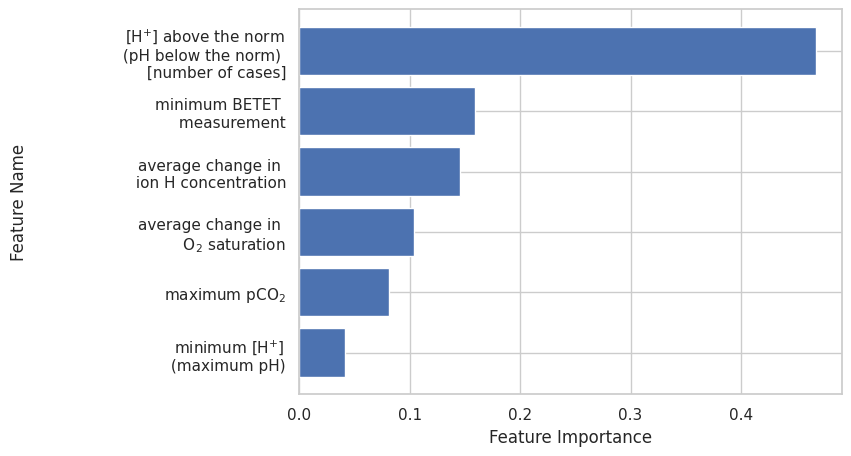

In [37]:


# Tworzenie wykresu słupkowego
niezerowe_wartosci = [x for x in wartosci if x != 0]
niezerowe_kategorie = [kategorie[i] for i, x in enumerate(wartosci) if x != 0]

#sortowanie
sorted_niezerowe_wartosci, sorted_niezerowe_kategorie = zip(*sorted(zip(niezerowe_wartosci, niezerowe_kategorie), reverse=False))

# Tworzenie wykresu słupkowego z niezerowymi wartościami
fig, ax = plt.subplots(figsize=(7,5))
plt.barh(sorted_niezerowe_kategorie, sorted_niezerowe_wartosci)

plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
ax.yaxis.set_label_coords(-0.5, 0.5)
plt.show()

In [38]:
from sklearn.tree import export_graphviz
import graphviz

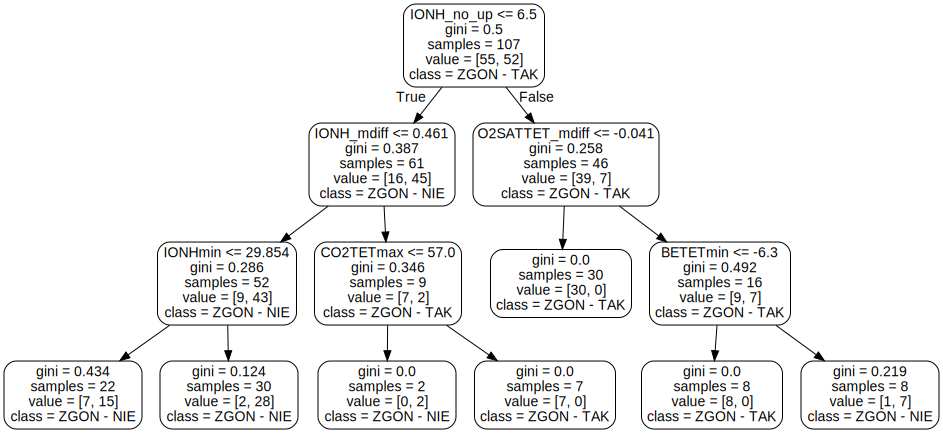

In [39]:
dot_data = export_graphviz(model, out_file=None,
                           feature_names=X.columns,
                           class_names=[ "ZGON - TAK","ZGON - NIE"],
                           filled=False, rounded=True)

graph = graphviz.Source(dot_data)

# Zapisz obrazek do pliku PNG
# graph.format = 'png'
# graph.render('drzewo_gazometria_cale_dane')
graph


In [40]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  model.fit(X.iloc[train_index], y.iloc[train_index])
  dot_data = export_graphviz(model, out_file=None,
                           feature_names=X.columns,
                           class_names=["ZGON - NIE", "ZGON - TAK"],
                           filled=False, rounded=True)
  graph = graphviz.Source(dot_data)
  graph.format = 'png'
  graph.render(f'drzewo_gazometria_{i}')



In [41]:
#srednia wynikow min i max
yeslist = ["PACJENT_NR","BETET", "IONH", "O2SATTET",  "CO2TET", "HCO3STTE", "HCO3ACTE", "O2TET", "PHTET"]
df_min2 = df6[yeslist].groupby('PACJENT_NR').min().add_suffix('min')
df_max2 = df6[yeslist].groupby('PACJENT_NR').max().add_suffix('max')

df_list2 = [df_zgon, df_size, df_min2, df_max2 ]
df_min_max = pd.concat(df_list2, axis=1)

#df_min_max['PHmin'] = -np.log10(df_min_max['IONHmin'])
#df_min_max['PHmax'] = -np.log10(df_min_max['IONHmax'])

df_min_max.head()

srednie = df_min_max.groupby('ZGON').mean()
print(srednie)

      BADANIE_NR_size  BETETmin    IONHmin  O2SATTETmin  CO2TETmin  \
ZGON                                                                 
0.0         29.384615 -2.726923  31.099515    80.405769  36.323077   
1.0         25.563636 -7.124242  35.809794    78.798182  37.899418   

      HCO3STTEmin  HCO3ACTEmin   O2TETmin  PHTETmin   BETETmax    IONHmax  \
ZGON                                                                        
0.0     21.909615    23.173077  52.250000  7.275737  12.476923  54.375331   
1.0     18.370303    20.218182  51.038182  7.151655  10.203636  73.405282   

      O2SATTETmax  CO2TETmax  HCO3STTEmax  HCO3ACTEmax    O2TETmax  PHTETmax  
ZGON                                                                          
0.0     99.521154  66.238462    34.001923    36.953846  189.611538  7.509250  
1.0     99.072727  81.349091    32.104182    36.127273  173.190909  7.455691  


In [42]:
# df_size = df0[['PACJENT_NR', 'BADANIE_NR']].groupby('PACJENT_NR').count().add_suffix('_size')
# pacjenci_wiecej_niz_6_badan = df_size[df_size['BADANIE_NR_size'] > 6].index

# df_filtered = df0[df0['PACJENT_NR'].isin(pacjenci_wiecej_niz_6_badan)]
# df_filtered1 = df_filtered[df_filtered['BADANIE_NR'] == 1]
# df_filtered1["ZGON"] = np.where(df_filtered1["ZGON"] == "NIE", 0, 1)
# df_filtered1.head()

# df_mean_1 = df_filtered1[yeslist].groupby('ZGON').mean().add_suffix('_mean')
# print(df_mean_1)
